In [1]:
#| default_exp differentiable_laziness
# from nbdev.showdoc import *
import numpy as np
%load_ext autoreload
%autoreload 2

# 02d Differentiable Diffusion Curvature
> A PyTorch implementation of diffusion curvature, suitable for use in loss functions
> Also enables GPU acceleration of laziness computation

In [2]:
#| export
import torch
from torch import sparse
def curvature(P, diffusion_powers = 8, aperture = 20, smoothing = 1, avg_transition_probabilities = True, precomputed_powered_P = None):
    """Same as the `curvature` function, but uses pytorch as backend instead of numpy. 
    Works on regular tensors (but not yet sparse tensors)
    """
    sample_number = 50
    row_partitions = torch.empty(sample_number)
    for idx, i in enumerate(torch.randint(P.shape[0], size = (sample_number,))):
        if P.is_sparse:
            row_partitions[idx] = torch.topk(P[i].values(), aperture, largest=True, sorted = True)[0][-1]
        else:
            row_partitions[idx] = torch.topk(P[i], aperture, largest=True, sorted = True)[0][-1]
    P_threshold = torch.mean(row_partitions)
    if P.is_sparse:
        P_thresholded = (P)
        raise NotImplementedError
    else:
        P_thresholded = (P >= P_threshold).to(int)
    # Compute powers of P
    if precomputed_powered_P is not None:
        P_powered = precomputed_powered_P
    else:
        P_powered = torch.linalg.matrix_power(P, diffusion_powers)
    near_neighbors_only = P_powered * P_thresholded
    if near_neighbors_only.is_sparse:
        laziness_aggregate = sparse.sum(near_neighbors_only,dim=[1]).to_dense()
    else:
        laziness_aggregate = torch.sum(near_neighbors_only, dim=1)
    laziness = laziness_aggregate
    if smoothing:
        average_laziness = P @ laziness[:,None]
        average_laziness = average_laziness.squeeze()
        laziness = average_laziness
    return laziness


# Testing for Dense Tensors

In [3]:
from diffusion_curvature.datasets import torus
from diffusion_curvature.core import DiffusionMatrix, plot_3d

In [4]:
X, ks = torus(n=5000)
P = DiffusionMatrix(X,kernel_type="adaptive anisotropic",k=20)

In [5]:
# turn P into a sparse tensor
P = torch.tensor(P)

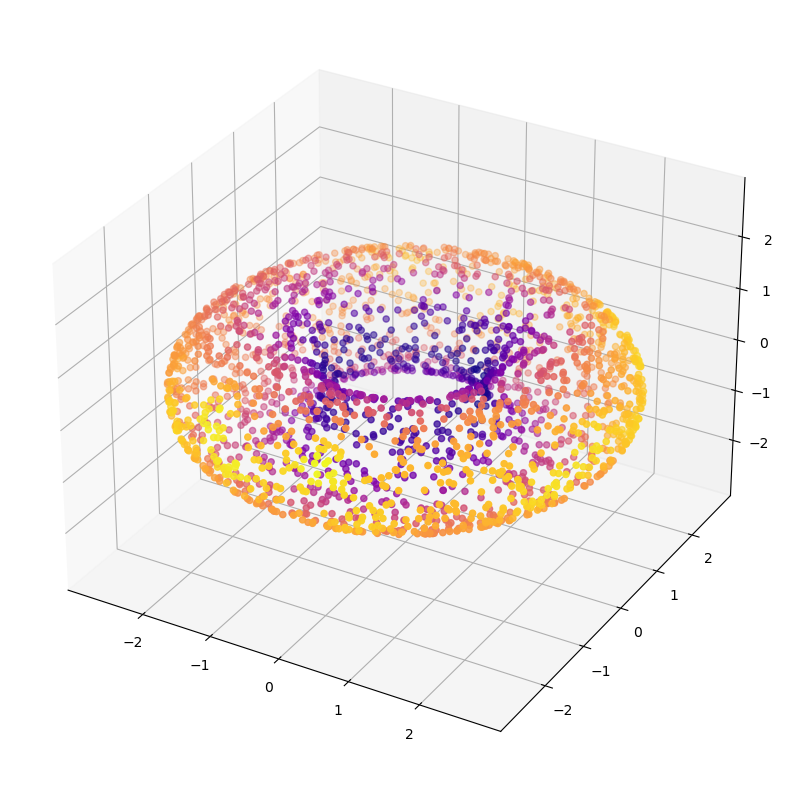

In [6]:
# calculate laziness
ks = curvature(P, diffusion_powers=32, aperture=20)
plot_3d(X, ks)

## Testing for Sparse Tensors

In [8]:
P_sparse = P.to_sparse()

In [15]:
(P_sparse.values() > 0.1).to(int)

tensor([0, 0, 0,  ..., 0, 0, 0])

In [ ]:
torch.max(P_sparse - 0.01)

In [17]:
P_sparse[1]

tensor(indices=tensor([[   0,    1,    2,  ..., 2471, 2472, 2473]]),
       values=tensor([4.5627e-05, 2.1577e-02, 7.3501e-07,  ...,
                      1.4352e-07, 7.0151e-17, 4.6378e-09]),
       size=(2474,), nnz=2474, dtype=torch.float64, layout=torch.sparse_coo)